# Práctica 3: Detector Germanio (Ge)
En esta práctica, se estudiaron las mediciones de espectro realizadas por un detector de Germanio *Canberra* de [Mirion Inc.](https://www.mirion.com/products/germanium-detectors) de los isótopos $^{22}\text{Na}$, $^{57}\mathrm{Co}$, $^{60}\text{Co}$ y $^{137}\text{Cs}$ en un espectro conjunto y otra de diferentes isótopos del Europio $^{152,154,155}\text{Eu}$. Se reunen los datos en los siguientes archivos:

| fuente gamma    | archivo                        |
|-----------------|--------------------------------|
| Varios          |  calibracionNaCoCoCs-Ge8K.xy   |
| Europio         |  calibracionEu-Ge8K.xy         |
-----------------------------------------------------


## Previo

Se importan los paquetes y se aplica el formato general


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as wid
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import colorcet as cc
import os
import copy
from matplotlib.patches import FancyBboxPatch
import uncertainties as un
from uncertainties.umath import *


Se configuran las gráficas, tengase en cuenta que algunos pueden no cargar por dependencias a instalar pendientes.


In [2]:
%matplotlib inline
mpl.rcParams.update(
    {
        "legend.fontsize": 20,
        "axes.labelsize": 24,  # Updated from 20 to 24
        "axes.titlesize": 24,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "figure.titlesize": 24,
        "axes.titlepad": 10,
        "text.usetex": True,
        "font.family": "Times New Roman",
        "mathtext.fontset": "dejavusans",
        "font.size": 20,
        "axes.labelweight": "bold",
        "axes.grid.which": "both",
        "axes.grid": True,
        "grid.alpha": 0.5,
        "axes.formatter.limits": (-3, 3),  # Use scientific notation for values outside the range 10^-3 to 10^3
        'figure.subplot.bottom': 0.2,
    }
)

colors = cc.glasbey_category10
# Configuracion de colores
k = 0

# Rotar la lista: número positivo para rotar a la derecha, negativo para rotar a la izquierda
colors = colors[-k:] + colors[:-k]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)

# Test
if False:
    plt.figure(figsize=(5, 5))
    plt.plot([1, 2, 3, 4], [1, 4, 9, 16], "o")
    plt.plot([4, 3, 2, 1], [1, 2, 3, 4], "o")
    plt.plot([1, 2, 3, 4], [1, 2, 3, 4], "s")
    plt.plot([4, 3, 2, 1], [1, 4, 9, 16], "s")
    plt.title("Test")
    plt.xlabel("X-axis Label", fontweight="bold")
    plt.ylabel("Y-axis Label")
    plt.show()

## 0. Preparación
Leemos los archivos

In [46]:
# Importar CSVs por pandas
mixed = pd.read_csv("calibracionNaCoCoCs-Ge8K.xy", sep=r'\s+', header=None)
eu = pd.read_csv("calibracionEu-Ge8K.xy", sep=r'\s+', header=None)

mixed_data = r"$^{22}\mathrm{Na}$" + "\n" + \
             r"$^{57}\mathrm{Co}$" + "\n" + \
             r"$^{60}\mathrm{Co}$" + "\n" + \
             r"$^{137}\mathrm{Cs}$"
data = {
    "mixed": {"file": mixed, "name": "Combinado"},
    "eu": {"file": eu, "name": r"$^{152,154,155}\mathrm{Eu}$"},
}
for key, value in data.items():
    df = value["file"]
    df.columns = ["canal", "cuentas"]
    df["canal"] = df["canal"].astype(int)
    df["cuentas"] = df["cuentas"].astype(int)
    data[key]["file"] = df  # Guardar el dataframe modificado

# test
if False:
    print(data["mixed"]["file"].head())
    print(mixed.head())

### Gráficas generales

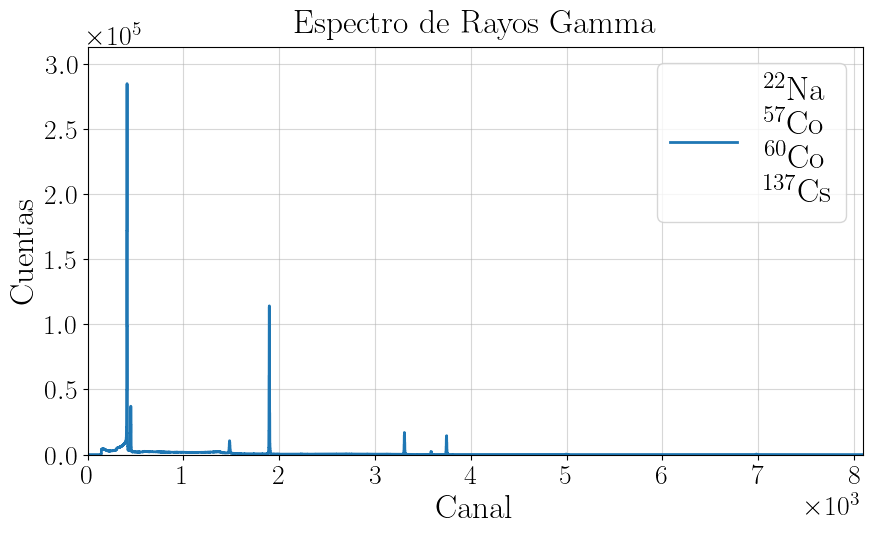

In [4]:
value = data["mixed"]

# gráfica
fig, ax = plt.subplots(figsize=(10, 6))
df = value["file"]
ax.plot(df["canal"], df["cuentas"], label=mixed_data, lw=2, ds="steps-mid")
ax.set_xlabel("Canal")
ax.set_ylabel("Cuentas")
ax.set_title("Espectro de Rayos Gamma")
ax.legend(fontsize=24)
ax.set_xlim(0, 8092)
ax.set_ylim(0, df["cuentas"].max() * 1.1)
fig.savefig("0_espectro_combinado_completo_normal.pdf")
plt.show()

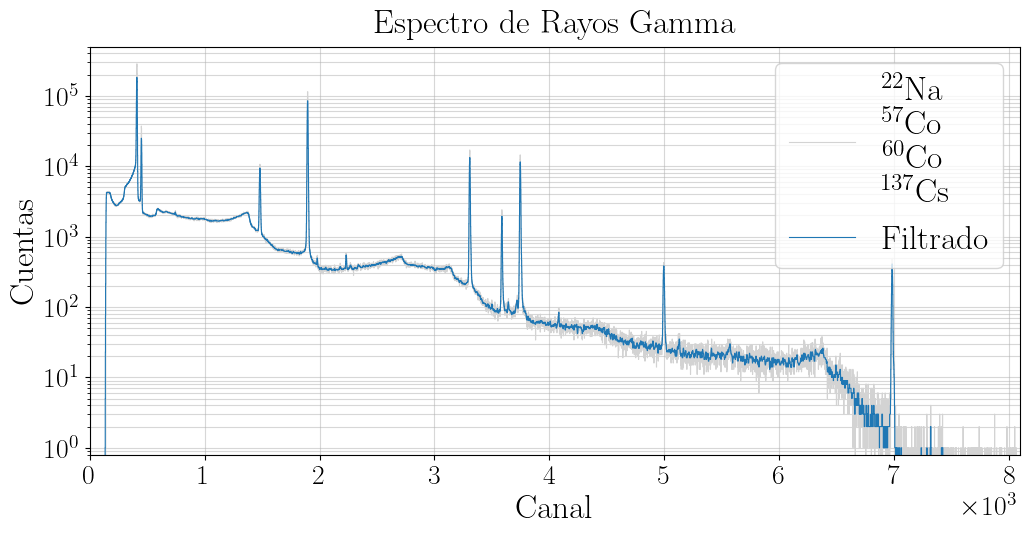

In [5]:
value = data["mixed"]
peaks = []
# aplicando filtro
df = value["file"]
y_filtered = gaussian_filter1d(df["cuentas"], 2.0)

# gráfica
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["canal"], df["cuentas"], label=mixed_data, lw=0.8, ds="steps-mid", color="lightgray")
ax.plot(df["canal"], y_filtered, label="Filtrado", lw=0.8, ds="steps-mid")
ax.set_xlabel("Canal")
ax.set_ylabel("Cuentas")
ax.set_title("Espectro de Rayos Gamma")
ax.legend(fontsize=24)
ax.set_xlim(0, 8092)
ax.set_yscale('log')
ax.set_ylim(0.8, 5e5)
fig.savefig("0_espectro_combinado_completo_semilog.pdf")
plt.show()


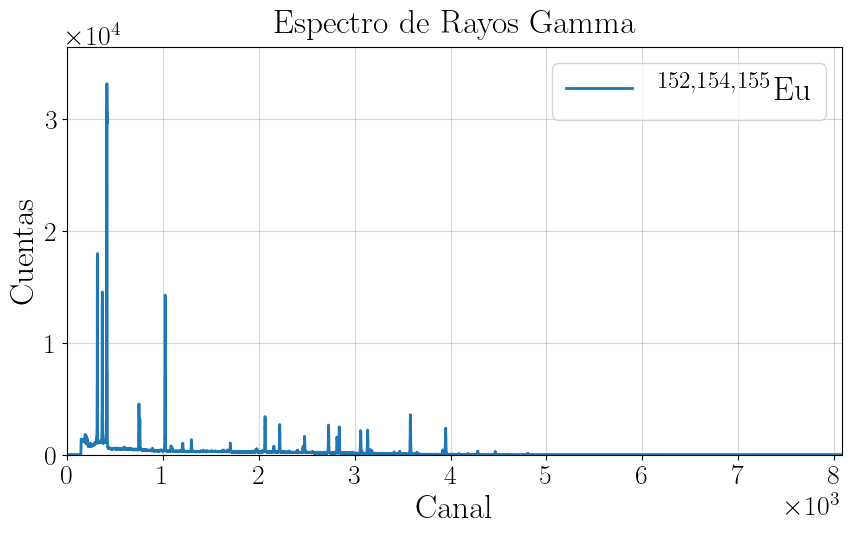

In [6]:
value = data["eu"]

# gráfica
fig, ax = plt.subplots(figsize=(10, 6))
df = value["file"]
ax.plot(df["canal"], df["cuentas"], label=value['name'], lw=2, ds="steps-mid")
ax.set_xlabel("Canal")
ax.set_ylabel("Cuentas")
ax.set_title("Espectro de Rayos Gamma")
ax.legend(fontsize=24)
ax.set_xlim(0, 8092)
ax.set_ylim(0, df["cuentas"].max() * 1.1)
fig.savefig("0_espectro_eu_completo_normal.pdf")
plt.show()

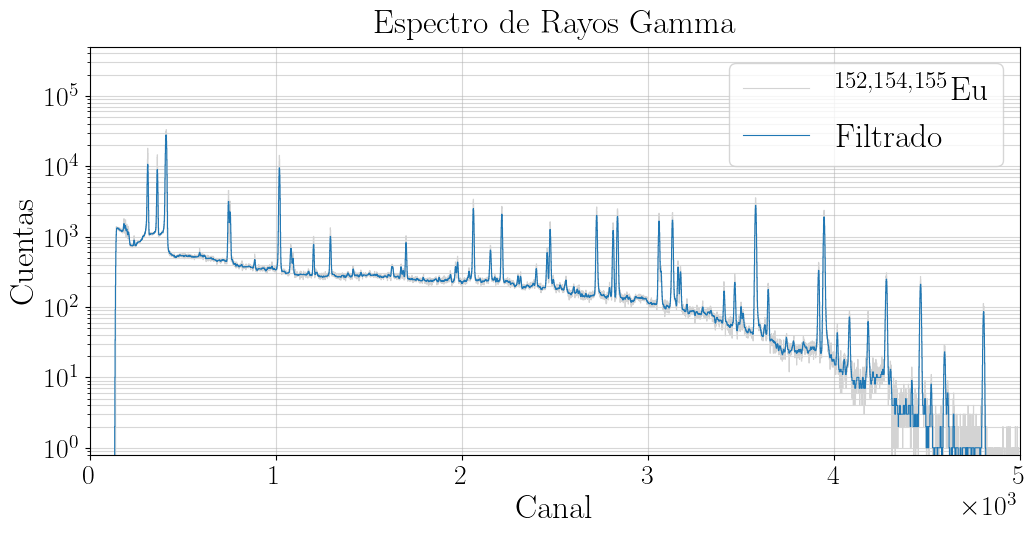

In [7]:
value = data["eu"]
peaks = []
# aplicando filtro
df = value["file"]
y_filtered = gaussian_filter1d(df["cuentas"], 2.0)

# gráfica
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["canal"], df["cuentas"], label=value['name'], lw=0.8, ds="steps-mid", color="lightgray")
ax.plot(df["canal"], y_filtered, label="Filtrado", lw=0.8, ds="steps-mid")
ax.set_xlabel("Canal")
ax.set_ylabel("Cuentas")
ax.set_title("Espectro de Rayos Gamma")
ax.legend(fontsize=24)
ax.set_xlim(0, 5000)
ax.set_yscale('log')
ax.set_ylim(0.8, 5e5)
fig.savefig("0_espectro_eu_completo_semilog.pdf")
plt.show()

## 1. Calibracion "combinado"

In [8]:
# clase para utilizar todos los métodos para gráficar organizado
class SpectrumAnalyzer:
    def __init__(self, data, element):
        self.data = data
        self.value = self.data[element]
        self.df = self.value["file"]
        self.params = {
            "centroid": [0, 0],
            "sigma": [0, 0],
            "amplitude": [0, 0],
            "a0": [0, 0],
            "a1": [0, 0],
            "area": [0, 0],
            "area_real":0,
        }
        self._popt = None
        self._pcov = None

    def gauss_bg(self, x, mu, sigma, A, a0, a1):
        return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x
    
    def gauss(self, x, mu, sigma, A):
        return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    def fit(self, params_0):
        # Parameters for the Gaussian
        df = self.df
        centroid = params_0["centroid"]
        sigma = params_0["sigma"]
        amplitude = params_0["amplitude"]
        x_range = params_0["x_range"]

        # Fit the Gaussian with background to the data within the specified x_range
        mask = (df["canal"] >= x_range[0]) & (df["canal"] <= x_range[1])
        mask_y = df["cuentas"][mask]
        # Initial guess for the background parameters
        a0_guess = df["cuentas"][df["canal"] == x_range[0]].values[0]
        a1_guess = df["cuentas"][df["canal"] == x_range[1]].values[0]

        #Fit the Gaussian with background to the data within the specified x_range
        popt, pcov = curve_fit(self.gauss_bg, df["canal"][mask], df["cuentas"][mask], p0=[centroid, sigma, amplitude, a0_guess, a1_guess])
        self._popt = popt
        self._pcov = pcov

        # Extract the fitted parameters
        self.params["centroid"][0], self.params["sigma"][0], self.params["amplitude"][0], self.params["a0"][0], self.params["a1"][0] = popt
        self.params["area"][0] = np.sqrt(2 * np.pi) * self.params["amplitude"][0] * self.params["sigma"][0]
        self.params["area"][1] = np.sqrt(np.diag(pcov)[2] * (2 * np.pi * self.params["sigma"][0])**2 + (self.params["amplitude"][0] * np.sqrt(2 * np.pi) * self.params["sigma"][1])**2)
        self.params["centroid"][1], self.params["sigma"][1], self.params["amplitude"][1], self.params["a0"][1], self.params["a1"][1] = np.sqrt(np.diag(pcov))


    def print(self):
        # Print the fitted parameters
        fwhm = 2 * np.sqrt(2 * np.log(2)) * self.params['sigma'][0]
        fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * self.params['sigma'][1]
        
        print(f"Fitted parameters with uncertainties:\n"
              f"Centroid: {self.params['centroid'][0]:.3f} ± {self.params['centroid'][1]:.3f}\n"
              f"Sigma: {self.params['sigma'][0]:.3f} ± {self.params['sigma'][1]:.3f}\n"
              f"Amplitude: {self.params['amplitude'][0]:.2f} ± {self.params['amplitude'][1]:.2f}\n"
              f"a0: {self.params['a0'][0]:.2f} ± {self.params['a0'][1]:.2f}\n"
              f"a1: {self.params['a1'][0]:.2f} ± {self.params['a1'][1]:.2f}\n"
              f"Area: {self.params['area'][0]:.2f} ± {self.params['area'][1]:.2f}\n"
              f"FWHM: {fwhm:.3f} ± {fwhm_uncertainty:.3f}\n")


    def plot(self, color):
        centroid = self.params["centroid"][0]
        sigma = self.params["sigma"][0]
        amplitude = self.params["amplitude"][0]
        x_range = params_0["x_range"]

        # Extract the fitted parameters
        fitted_a0 = self.params["a0"][0]
        fitted_a1 = self.params["a1"][0]
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        ax.plot(self.df["canal"], self.df["cuentas"], label=value["name"], marker="x", ds="steps-mid")
        ax.set_xlabel("Canal")
        ax.set_ylabel("Cuentas")
        ax.set_title(f"Espectro  Gamma {value['name']}")

        x = np.linspace(x_range[0], x_range[1], 1000)
        gaussian_with_bg_fitted = self.gauss_bg(x, *self._popt)

        # Plot the fitted Gaussian with background
        ax.plot(x, gaussian_with_bg_fitted, label="Ajuste Gaussiano", color=color, linestyle='-')

        # Generate x values for the background line
        x_bg = np.array([x_range[0], x_range[1]])
        # Generate y values for the background line using the fitted background parameters
        y_bg = fitted_a0 + fitted_a1 * x_bg
        # Fill area under the fitted Gaussian with background
        ax.fill_between(x, np.interp(x, x_bg, y_bg), gaussian_with_bg_fitted, alpha=0.2, label="Intensidad", color=color)

        # Fill area under Gaussian with background
        ax.set_xlim(centroid - 7 * sigma, centroid + 5 * sigma)
        ax.set_ylim(0, max(gaussian_with_bg_fitted) * 1.1)
        ax.legend(loc='upper left')
        return fig, ax


Fitted parameters with uncertainties:
Centroid: 6982.452 ± 0.055
Sigma: 3.227 ± 0.068
Amplitude: 470.30 ± 7.31
a0: -2258.08 ± 2062.76
a1: 0.33 ± 0.30
Area: 3804.41 ± 148.21
FWHM: 7.599 ± 0.161



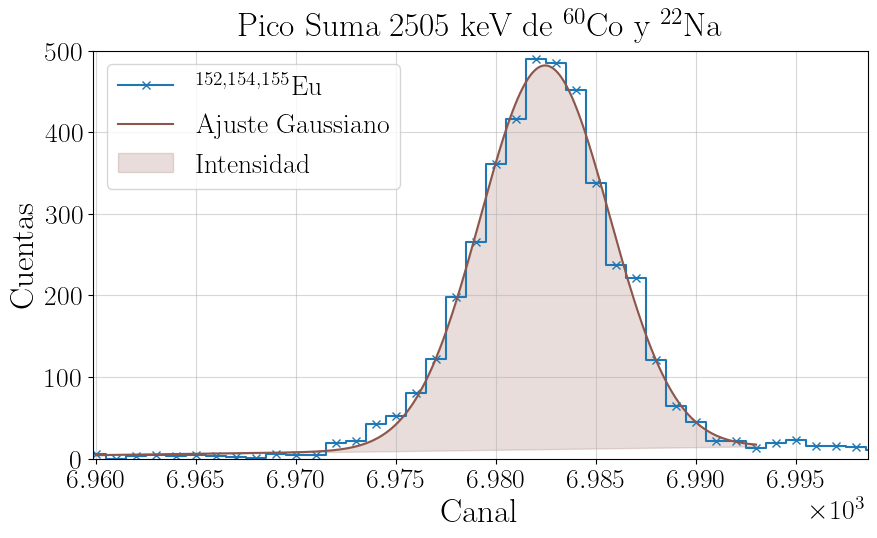

In [9]:
element = 'mixed'
params_0 = {
    "centroid": 6981,
    "sigma": 1,
    "amplitude": 499,
    "x_range": [6960, 6993]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[5])
ax.set_title("Pico Suma 2505 keV de $^{60}$Co y $^{22}$Na")
ax.set_ylim(0, 500)
fig.savefig("1_pico_suma1_2505keV.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 3746.461 ± 0.019
Sigma: 2.612 ± 0.020
Amplitude: 14350.72 ± 92.38
a0: -8056.94 ± 6892.87
a1: 2.21 ± 1.84
Area: 93960.75 ± 1516.21
FWHM: 6.151 ± 0.048



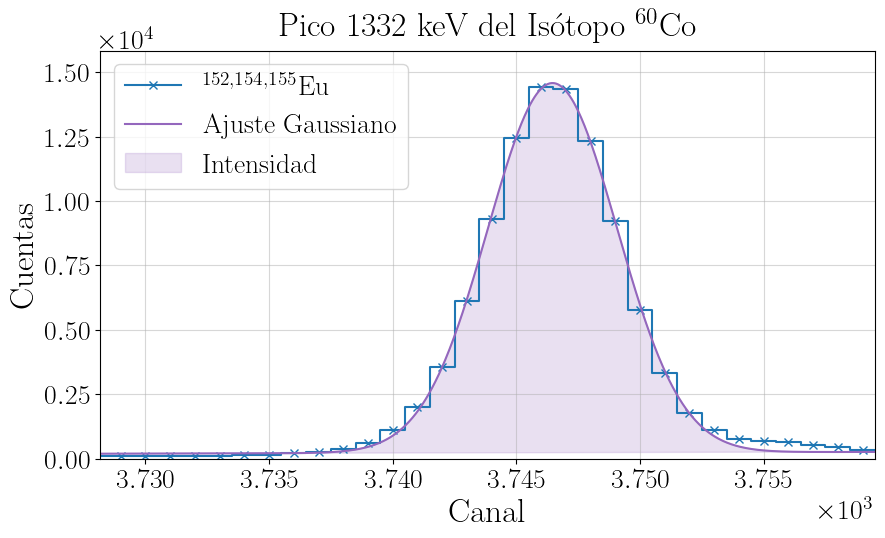

In [10]:
element = 'mixed'
params_0 = {
    "centroid": 3.746e3,
    "sigma": 1,
    "amplitude": 15837,
    "x_range": [3726, 3770]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[4])
ax.set_title("Pico 1332 keV del Isótopo $^{60}$Co")
ax.set_ylim(0, 1.584e4)
fig.savefig("1_pico_60Co_1332keV.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 3586.641 ± 0.020
Sigma: 2.520 ± 0.022
Amplitude: 2315.63 ± 16.62
a0: -7639.08 ± 1068.73
a1: 2.17 ± 0.30
Area: 14624.75 ± 263.11
FWHM: 5.933 ± 0.053



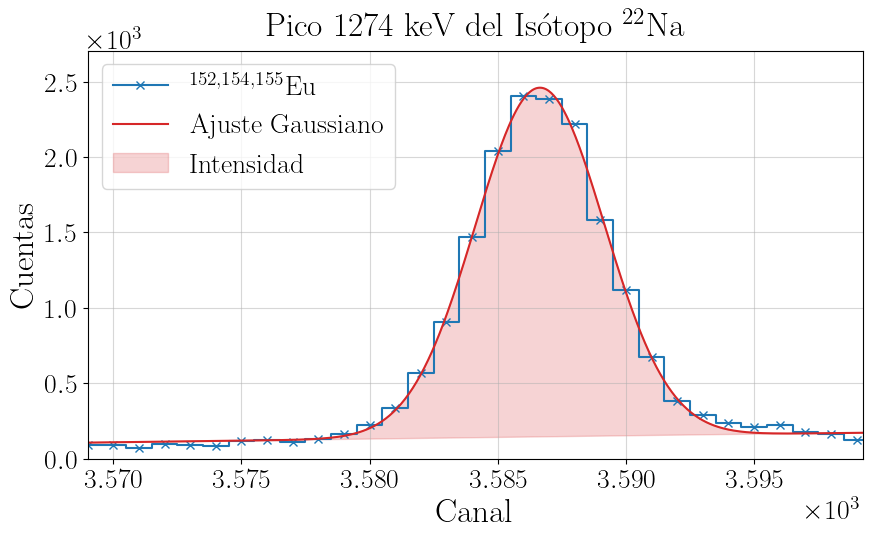

In [11]:
element = 'mixed'
params_0 = {
    "centroid": 3.585e3,
    "sigma": 2,
    "amplitude": 4.6e3,
    "x_range": [3550, 3600]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[3])
ax.set_title("Pico 1274 keV del Isótopo $^{22}$Na")
fig.savefig("1_pico_22Na_1274keV.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 1896.496 ± 0.012
Sigma: 2.221 ± 0.012
Amplitude: 114552.75 ± 547.00
a0: -547.66 ± 4450.70
a1: 0.73 ± 2.36
Area: 637838.79 ± 7634.58
FWHM: 5.231 ± 0.029



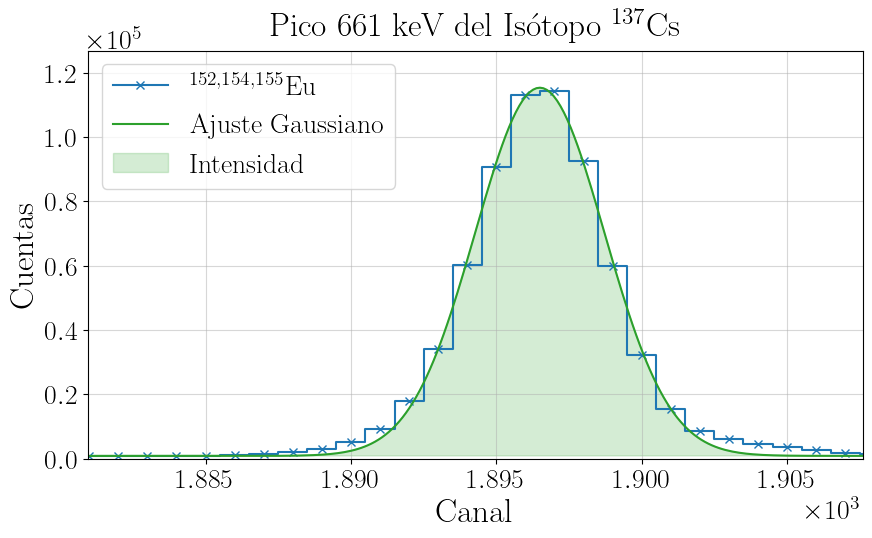

In [12]:
element = 'mixed'
params_0 = {
    "centroid": 1.9e3,
    "sigma": 1.20,
    "amplitude": 1e5,
    "x_range": [1830, 1948]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[2])
ax.set_title("Pico 661 keV del Isótopo $^{137}$Cs")
fig.savefig("1_pico_137Cs_661keV.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 410.614 ± 0.023
Sigma: 1.646 ± 0.024
Amplitude: 274932.84 ± 3352.02
a0: 133464.02 ± 23088.26
a1: -301.70 ± 54.97
Area: 1134672.03 ± 34676.92
FWHM: 3.877 ± 0.057



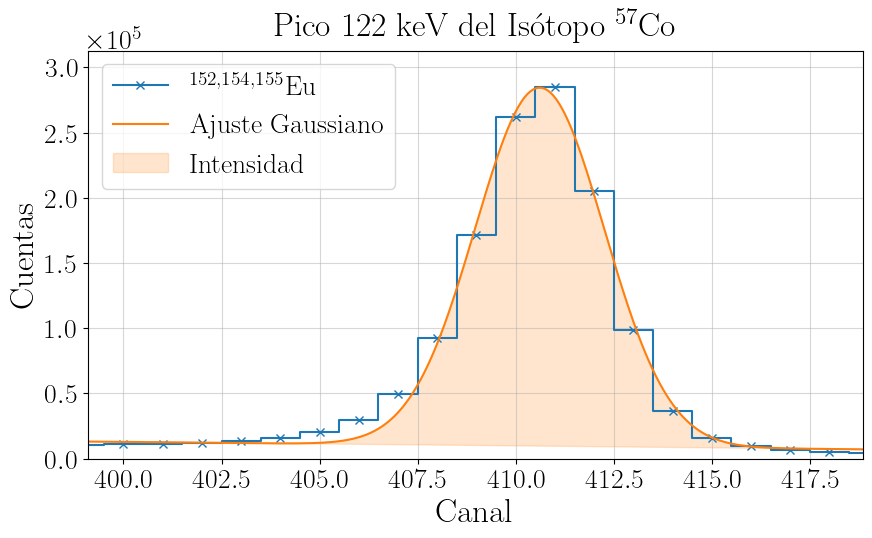

In [13]:
element = 'mixed'
params_0 = {
    "centroid": 410.55,
    "sigma": 1.20,
    "amplitude": 34000,
    "x_range": [396, 440]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[1])
ax.set_title("Pico 122 keV del Isótopo $^{57}$Co")
fig.savefig("1_pico_57Co_122keV.pdf")
plt.show()

## 2. Calibración Eu

Fitted parameters with uncertainties:
Centroid: 4467.270 ± 0.023
Sigma: 2.712 ± 0.024
Amplitude: 258.51 ± 1.89
a0: -67.73 ± 86.68
a1: 0.02 ± 0.02
Area: 1757.26 ± 32.24
FWHM: 6.386 ± 0.055



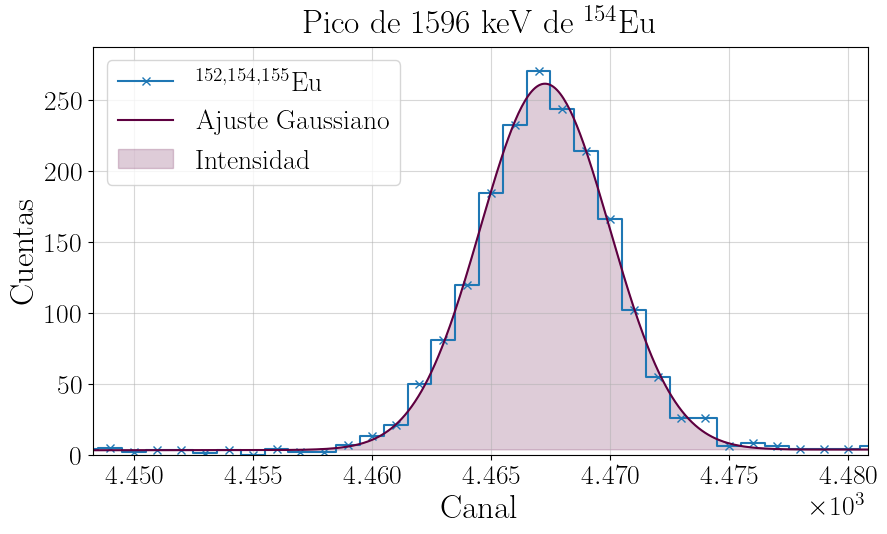

In [14]:
# 7 pico de Eu 1596.5 keV
element = 'eu'
params_0 = {
    "centroid": 4467,
    "sigma": 1,
    "amplitude": 263,
    "x_range": [4430, 4500]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[13])
ax.set_title("Pico de 1596 keV de $^{154}$Eu")
fig.savefig("2_pico_eu154_1596keV.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 3580.559 ± 0.011
Sigma: 2.468 ± 0.012
Amplitude: 3511.62 ± 13.95
a0: -72.28 ± 549.81
a1: 0.04 ± 0.15
Area: 21725.86 ± 216.31
FWHM: 5.812 ± 0.027



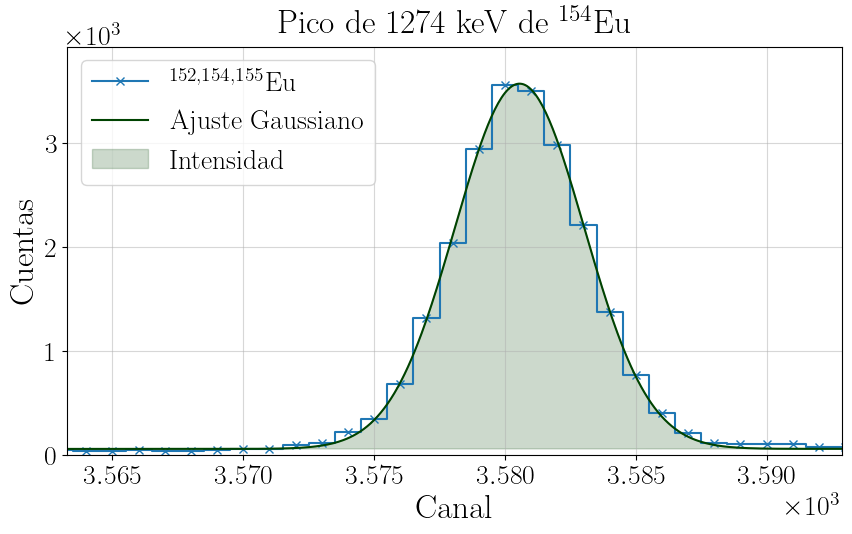

In [15]:
# 6 pico de Eu 1274.5 keV
element = 'eu'
params_0 = {
    "centroid": 3580,
    "sigma": 1,
    "amplitude": 3396,
    "x_range": [3553, 3618]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[11])
ax.set_title("Pico de 1274 keV de $^{154}$Eu")
fig.savefig("2_pico_eu154_1274keV.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 2725.834 ± 0.016
Sigma: 2.267 ± 0.017
Amplitude: 2449.71 ± 15.26
a0: -1140.55 ± 639.07
a1: 0.48 ± 0.23
Area: 13922.93 ± 217.33
FWHM: 5.339 ± 0.040



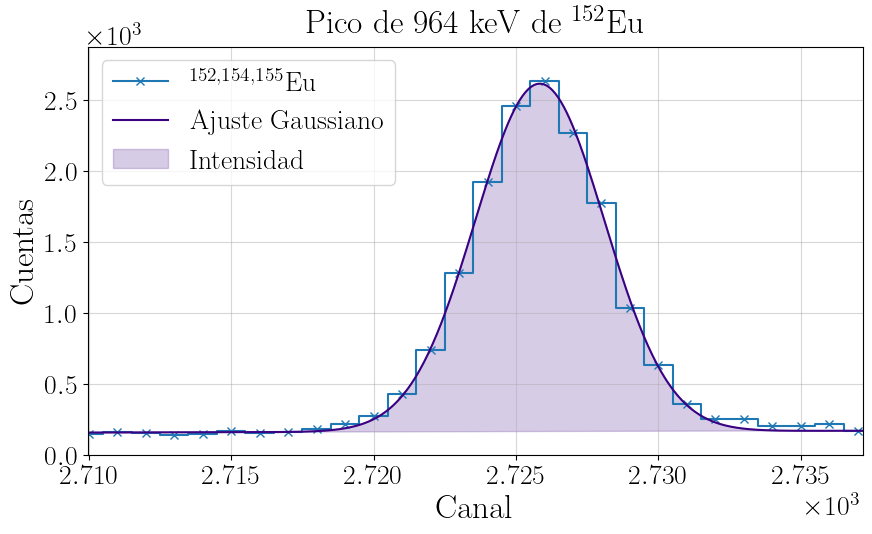

In [16]:
# 5 pico de Eu 964.1 keV
element = 'eu'
params_0 = {
    "centroid": 2723,
    "sigma": 1,
    "amplitude": 2.5e3,
    "x_range": [2700, 2750]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[10])
ax.set_title("Pico de 964 keV de $^{152}$Eu")
fig.savefig("2_pico_eu152_964keV.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 2062.903 ± 0.014
Sigma: 2.063 ± 0.015
Amplitude: 3114.85 ± 18.37
a0: 2450.25 ± 1019.22
a1: -1.06 ± 0.49
Area: 16110.26 ± 238.21
FWHM: 4.859 ± 0.035



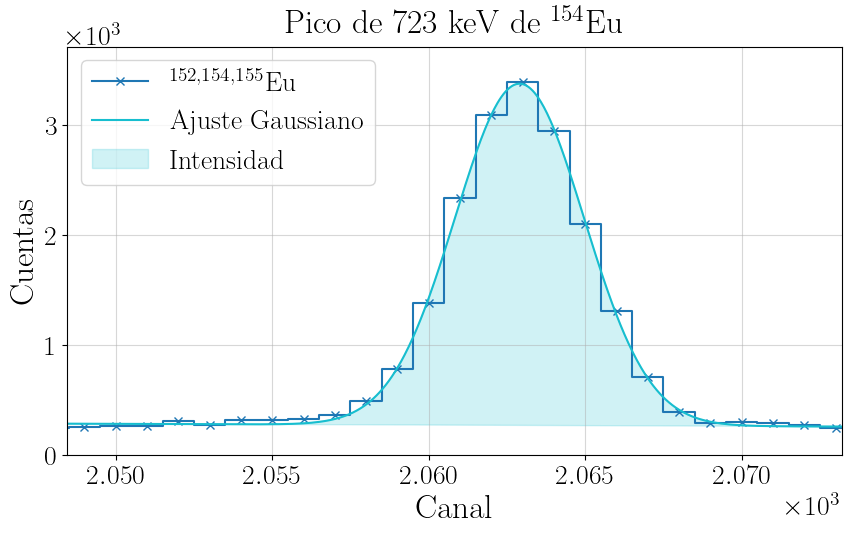

In [17]:
# 4 pico de Eu 723.3 keV
element = 'eu'
params_0 = {
    "centroid": 2063,
    "sigma": 1,
    "amplitude": 2.4e3,
    "x_range": [2047, 2080]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[9])
ax.set_title("Pico de 723 keV de $^{154}$Eu")
fig.savefig("2_pico_eu154_723keV.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 1020.100 ± 0.007
Sigma: 1.753 ± 0.008
Amplitude: 13826.99 ± 51.24
a0: 1176.31 ± 542.23
a1: -0.80 ± 0.53
Area: 60748.43 ± 564.32
FWHM: 4.127 ± 0.018



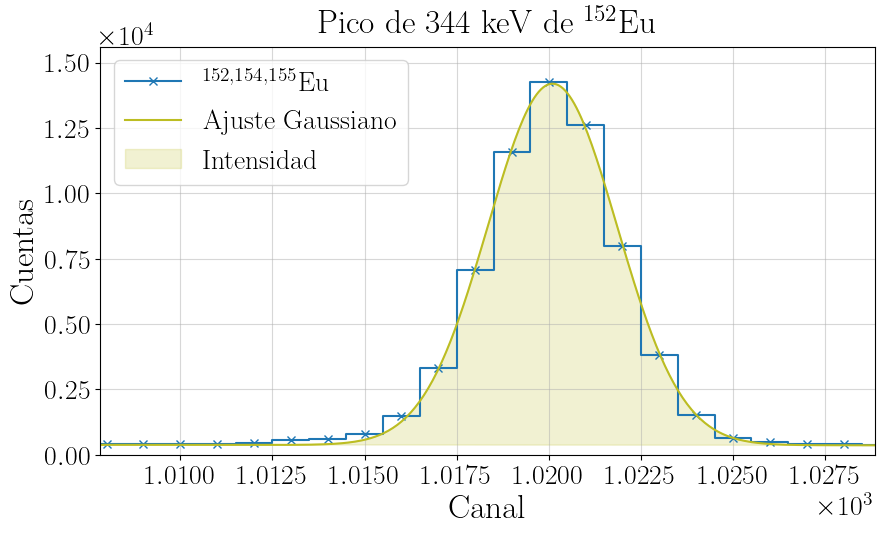

In [18]:
# 3 pico de Eu 344.3 keV
element = 'eu'
params_0 = {
    "centroid": 1020,
    "sigma": 1,
    "amplitude": 9.2e3,
    "x_range": [990, 1050]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[8])
ax.set_title("Pico de 344 keV de $^{152}$Eu")
fig.savefig("2_pico_eu152_344keV.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 363.679 ± 0.014
Sigma: 1.413 ± 0.015
Amplitude: 13639.72 ± 121.43
a0: 1910.91 ± 880.03
a1: -2.10 ± 2.47
Area: 48321.67 ± 1078.33
FWHM: 3.328 ± 0.035



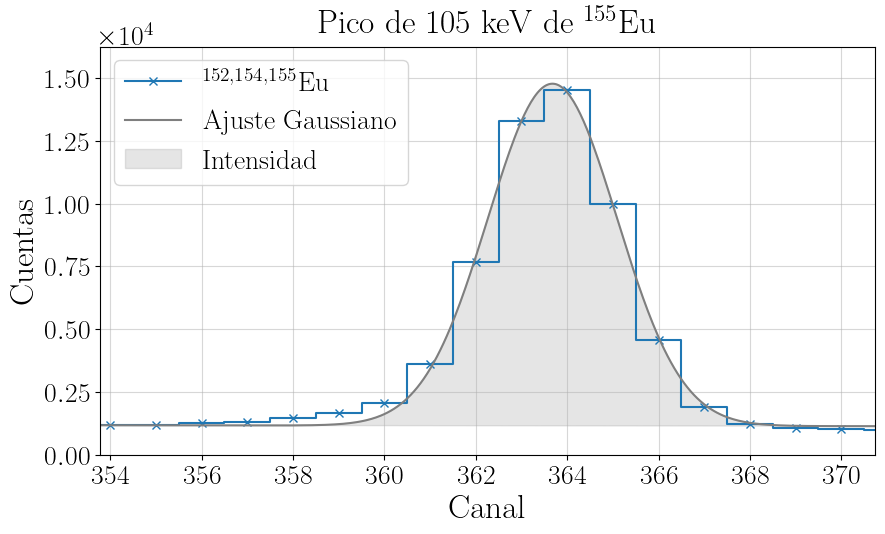

In [19]:
# 2 pico de Eu 105.3 keV
element = 'eu'
params_0 = {
    "centroid": 362,
    "sigma": 1,
    "amplitude": 19023,
    "x_range": [340, 376]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[7])
ax.set_title("Pico de 105 keV de $^{155}$Eu")
fig.savefig("2_pico_eu152_105keV.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 312.155 ± 0.017
Sigma: 1.369 ± 0.018
Amplitude: 16732.60 ± 181.83
a0: 1706.04 ± 938.97
a1: -1.69 ± 3.03
Area: 57421.15 ± 1564.09
FWHM: 3.224 ± 0.041



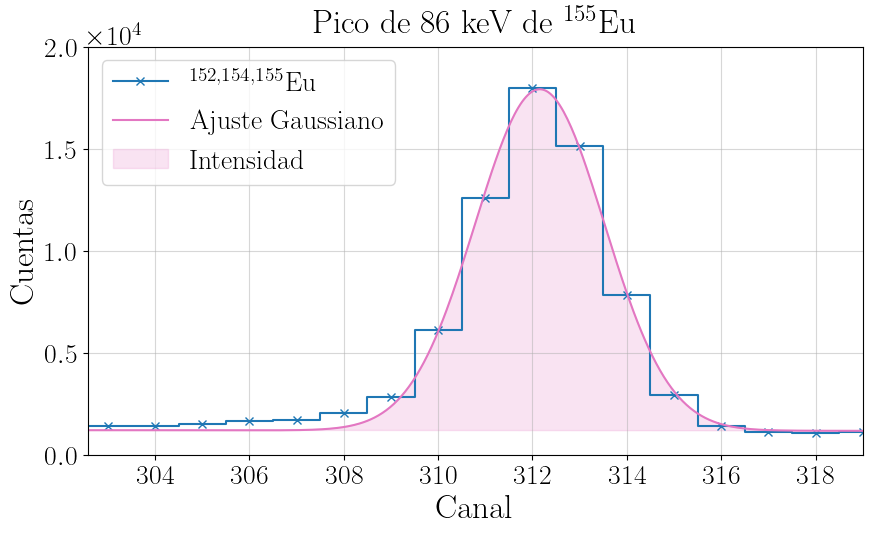

In [20]:
# Primer pico de Eu 
element = 'eu'
params_0 = {
    "centroid": 312,
    "sigma": 1,
    "amplitude": 19023,
    "x_range": [290, 330]
}
spectra = SpectrumAnalyzer(data, element)
spectra.fit(params_0)
spectra.print()
fig, ax = spectra.plot(colors[6])
ax.set_title("Pico de 86 keV de $^{155}$Eu")
ax.set_ylim(0, 2e4)
fig.savefig("2_pico_eu155_86keV.pdf")
plt.show()

## 3.Calibracion Energia y FWMH

### Calibración Final

Se utilizan los datos de la tabla a continuación que representan la COMBINADA

| $E_\gamma$ (keV) | canal        | $\sigma$ (canales) | $I_\gamma$ (cuentas)  |
|------------------|--------------|--------------------|-----------------------|
| 122.1            | 410.614(23)  | 1.646(24)          | $1.13(35)\times 10^6$ |
| 661.7            | 1896.50(12)  | 2.221(12)          | $6.4(1)\times10^5$    |
| 1274.5           | 3586.66(26)  | 2.520(22)          | $1.462(26)\times10^4$ |
| 1332.5           | 3746.461(19) | 2.612(20)          | $9.40(15)\times10^4$  |
| 2505.7           | 6982.45(5)   | 3.23(7)            | $3.80(15)\times 10^3$ |


In [21]:
def linealizacion(canal, E_gamma, sigma):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, canal, E_gamma, sigma=sigma, absolute_sigma=True)
    a, b = popt
    da, db = np.sqrt(np.diag(pcov))

    # Generar valores ajustados
    x_fit = np.linspace(min(canal), max(canal), 100)
    y_fit = a * x_fit + b


    # Imprimir los datos de ajuste c0 y c1
    print(f"c0 = {b:.3f} ± {db:.3f}")
    print(f"c1 = {a:.8e} ± {da:.3e}")

    # Graficar datos y ajuste
    ax.axline(
        (0, b), slope=a, color="darkred", lw=3,
        label="Ajuste lineal\n" + r"$E_{\gamma}$[keV]$=c_0 + c_1 \, x$[canal]"
    )
    ax.errorbar(
        canal,
        E_gamma,
        xerr=sigma,
        fmt=".",
        color="lightblue",
        ecolor="darkblue",
        capsize=0,
        lw=2,
        markersize=16,
        label="Medidas",
        markeredgecolor="darkblue",
        markeredgewidth=2
    )
    # Calcular r^2
    residuals = E_gamma - (a * canal + b)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((E_gamma - np.mean(E_gamma))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Añadir texto en la gráfica
    ax.text(
        0.95, 0.05,
        f"$R^2 = {r_squared:.4f}$",
        verticalalignment='bottom',
        horizontalalignment='right',
        transform=ax.transAxes,
        color='black',
        fontsize=30
    )
    ax.legend()
    ax.set_xlabel("$x$ (canal)")
    ax.set_ylabel("Energía (keV)")
    return fig, ax


c0 = -26.612 ± 1.565
c1 = 3.62727818e-01 ± 5.002e-04


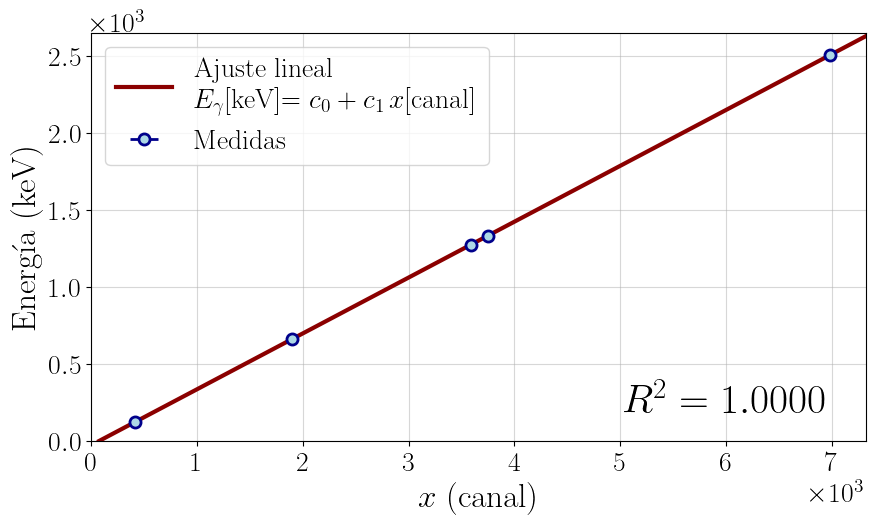

In [22]:
# Arrays de los valores de la tabla
E_gamma = np.array([122.1, 661.7, 1274.5, 1332.5, 2505.7])
canal = np.array([410.614, 1896.50, 3586.66, 3746.461, 6982.45])
sigma = np.array([1.646, 2.221, 2.612, 2.612, 3.23])
I_gamma = np.array([1.13e6, 6.4e5, 1.462e4, 9.40e4, 3.80e3])

# Arrays de las incertidumbres
u_canal = np.array([0.023, 0.12, 0.26, 0.019, 0.05])
u_sigma = np.array([0.024, 0.012, 0.020, 0.020, 0.06])
u_I_gamma = np.array([3.5e5, 1.0e4, 2.6e2, 1.5e3, 1.2e2])

fig, ax = linealizacion(canal, E_gamma, sigma)
ax.set_ylim(0, 2650)
ax.set_xlim(0, 7327)
fig.savefig("3_calibracion_combinado.pdf")
plt.show()

# c0 es b interseccion.
# c1 es a pendiente.

| $E_\gamma$ (keV) | canal        | $\sigma$ (canales) | $I_\gamma$ (cuentas)  |
|------------------|--------------|--------------------|-----------------------|
| 86.5             | 312.155(17)  | 1.369(18)          | $5.742(15)\times10^4$ |
| 105.3            | 363.679(14)  | 1.413(15)          | $4.832(11)\times10^4$ |
| 344.3            | 1020.100(7)  | 1.75(1)            | $6.075(56)\times10^4$ |
| 723.3            | 2062.903(14) | 2.063(15)          | $1.611(23)\times10^4$ |
| 964.1            | 2725.834(16) | 2.267(17)          | $1.392(22)\times10^4$ |
| 1274.5           | 3580.559(11) | 2.468(12)          | $2.170(21)\times10^4$ |
| 1596.5           | 6982.45(6)   | 3.23(7)            | $3.80(15)\times 10^3$ |

c0 = -26.787 ± 0.997
c1 = 3.63459247e-01 ± 5.184e-04


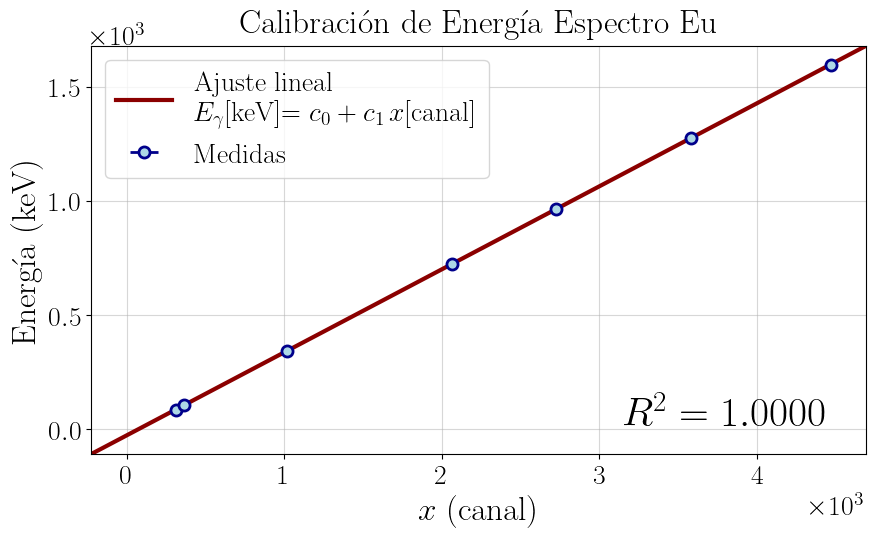

In [23]:
E_gamma = np.array([86.5, 105.3, 344.3, 723.3, 964.1, 1274.5, 1596.5])
canal = np.array([312.155, 363.679, 1020.1, 2062.903, 2725.834, 3580.559, 4467.27])
u_canal = np.array([0.017, 0.014, 0.007, 0.014, 0.016, 0.011, 0.023])
sigma = np.array([1.369, 1.413, 1.753, 2.063, 2.267, 2.468, 2.712])
u_sigma = np.array([0.018, 0.015, 0.008, 0.015, 0.017, 0.012, 0.024])
I_gamma = np.array([5.742e4, 4.832e4, 6.075e4, 1.611e4, 1.392e4, 2.170e4, 1.757e3])
u_I_gamma = np.array([1.5e2, 1.1e2, 5.6e2, 2.3e2, 2.2e2, 2.1e2, 3.2e1])

fig, ax = linealizacion(canal, E_gamma, sigma)
# ax.set_ylim(0, 2650)
# ax.set_xlim(0, 5300)

# c0 es b interseccion.
# c1 es a pendiente.
ax.set_title("Calibración de Energía Espectro Eu")
fig.savefig("3_calibracion_eu.pdf")
plt.show()

#### FWHM linealizacion

In [24]:
c1_mix = un.ufloat(3.62727818e-01, 5.002e-04)
c1_eu = un.ufloat(3.63459247e-01, 5.184e-04)

c0_mix = un.ufloat(-26.612, 1.565)
c0_eu = un.ufloat(-26.787, 0.997)

c1_mean = (c1_mix + c1_eu) / 2
c0_mean = (c0_mix + c0_eu) / 2
print(f"Mean of c1's: {c1_mean}")
print(f"Mean of c0's: {c0_mean}")


c0 = c0_mean
c1 = c1_mean
# Calibracion momentanea
def energia(canal):
    return c1 * canal

def canal(energia):
    return (energia - c0) / c1

energia(3.88)

Mean of c1's: 0.3631+/-0.0004
Mean of c0's: -26.7+/-0.9


1.4088029060999998+/-0.0013975254255146844

| $E_\gamma$ (keV) | canal        | 
|------------------|--------------|
| 86.5             | 312.155(17)  | 
| 105.3            | 363.679(14)  | 
| 344.3            | 1020.100(7)  | 
| 723.3            | 2062.903(14) | 
| 964.1            | 2725.834(16) |
| 1274.5           | 3580.559(11) | 
| 1596.5           | 6982.45(6)   | 

In [25]:
def linealizacion_FWHM(canal, E_gamma, sigma):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, canal, E_gamma, sigma=sigma, absolute_sigma=True)
    a, b = popt
    da, db = np.sqrt(np.diag(pcov))

    # Generar valores ajustados
    x_fit = np.linspace(min(canal), max(canal), 100)
    y_fit = a * x_fit + b


    # Imprimir los datos de ajuste c0 y c1
    print(f"c0 = {b:.3f} ± {db:.3f}")
    print(f"c1 = {a:.8e} ± {da:.3e}")

    # Graficar datos y ajuste
    ax.axline(
        (0, b), slope=a, color="darkred", lw=3,
        label="Ajuste lineal\n" + r"$FWHM$[keV]$=\ell_0 + \ell_1 \, E_{\gamma}$[keV]"
    )
    ax.errorbar(
        canal,
        E_gamma,
        xerr=sigma,
        fmt=".",
        color="lightgreen",
        ecolor="darkgreen",
        capsize=0,
        lw=2,
        markersize=16,
        label="Medidas",
        markeredgecolor="darkgreen",
        markeredgewidth=2
    )
    # Calcular r^2
    residuals = E_gamma - (a * canal + b)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((E_gamma - np.mean(E_gamma))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Añadir texto en la gráfica
    ax.text(
        0.05, 0.95,
        f"$R^2 = {r_squared:.4f}$",
        verticalalignment='top',
        horizontalalignment='left',
        transform=ax.transAxes,
        color='black',
        fontsize=30
    )
    ax.legend()
    ax.set_xlabel("Energía (keV)")
    ax.set_ylabel("$FWHM$ (keV)")
    return fig, ax


In [26]:
def linealizacion_FWHM_raiz(canal, E_gamma, sigma):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    popt, pcov = curve_fit(lambda x, a, b: a * np.sqrt(x) + b, canal, E_gamma, sigma=sigma, absolute_sigma=True)
    a, b = popt
    da, db = np.sqrt(np.diag(pcov))
    # Calcular r^2
    residuals = E_gamma - (a * np.sqrt(canal) + b)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((E_gamma - np.mean(E_gamma))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Generar valores ajustados
    x_fit = np.linspace(min(canal), max(canal), 100)
    y_fit = a * np.sqrt(x_fit) + b

    
    # Imprimir los datos de ajuste c0 y c1
    print(f"c0 = {b:.3f} ± {db:.3f}")
    print(f"c1 = {a:.8e} ± {da:.3e}")

    # Graficar datos y ajuste
    ax.plot(x_fit, y_fit, color="darkred", lw=3, label="Ajuste Potencial\n" + r"$FWHM$[keV]$=f_0 + f_1 \, E_{\gamma}$[keV]$^{1/2}$")
    ax.errorbar(
        canal,
        E_gamma,
        xerr=sigma,
        fmt=".",
        color="#FFA07A",
        ecolor="darkorange",
        capsize=0,
        lw=2,
        markersize=16,
        label="Medidas",
        markeredgecolor="darkorange",
        markeredgewidth=2
    )
    # Añadir texto en la gráfica
    ax.text(
        0.05, 0.95,
        f"$R^2 = {r_squared:.4f}$",
        verticalalignment='top',
        horizontalalignment='left',
        transform=ax.transAxes,
        color='black',
        fontsize=30
    )
    ax.legend()
    ax.set_xlabel("Energía (keV)")
    ax.set_ylabel("$FWHM$ (keV)")
    return fig, ax


c0 = 1.399 ± 0.001
c1 = 5.84802331e-04 ± 1.167e-06


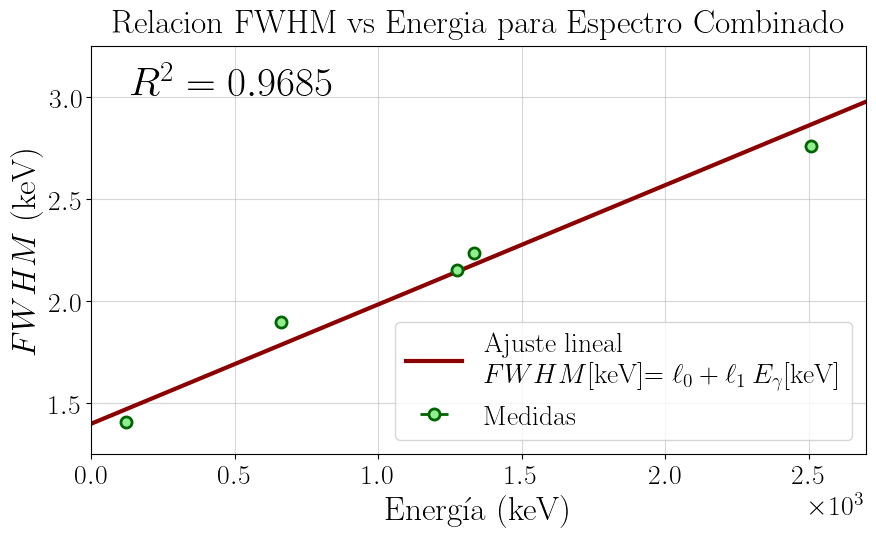

In [27]:
# Energia lineal mixed
E_gamma_mix = np.array([122.1, 661.7, 1274.5, 1332.5, 2505.7])
fwhm_mix = [3.88, 5.23, 5.93, 6.15, 7.60]
u_fwhm_mix = [0.06, 0.03, 0.05, 0.05, 0.16]
fwhm = [un.ufloat(fwhm_mix[i], u_fwhm_mix[i]) for i in range(len(fwhm_mix))]
fwhm_energia_mix = np.array([energia(fwhm_mix[i]).nominal_value for i in range(len(fwhm_mix))])
u_fwhm_energia_mix = np.array([energia(fwhm_mix[i]).std_dev for i in range(len(fwhm_mix))])
fig, ax = linealizacion_FWHM(E_gamma_mix, fwhm_energia_mix, u_fwhm_energia_mix)
ax.set_title("Relacion FWHM vs Energia para Espectro Combinado")
ax.set_ylim(1.25, 3.25)
ax.set_xlim(0, 2700)
fig.savefig("3_FWHM_lineal_mix.pdf")
plt.show()

c0 = 1.036 ± 0.002
c1 = 3.30898839e-02 ± 6.527e-05


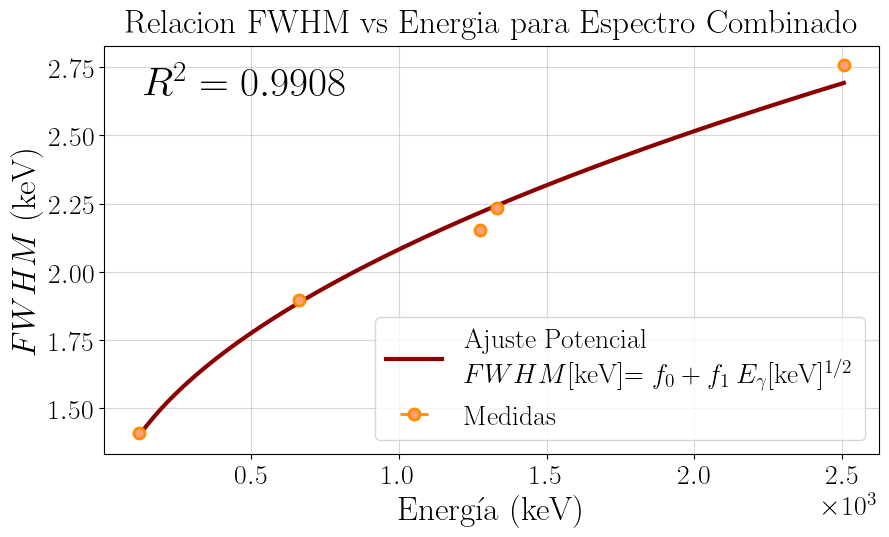

In [28]:
# Energia lineal mixed
E_gamma_mix = np.array([122.1, 661.7, 1274.5, 1332.5, 2505.7])
fwhm_mix = [3.88, 5.23, 5.93, 6.15, 7.60]
u_fwhm_mix = [0.06, 0.03, 0.05, 0.05, 0.16]
fwhm = [un.ufloat(fwhm_mix[i], u_fwhm_mix[i]) for i in range(len(fwhm_mix))]
fwhm_energia_mix = np.array([energia(fwhm_mix[i]).nominal_value for i in range(len(fwhm_mix))])
u_fwhm_energia_mix = np.array([energia(fwhm_mix[i]).std_dev for i in range(len(fwhm_mix))])
fig, ax = linealizacion_FWHM_raiz(E_gamma_mix, fwhm_energia_mix, u_fwhm_energia_mix)
ax.set_title("Relacion FWHM vs Energia para Espectro Combinado")
fig.savefig("3_FWHM_loglog_mix.pdf")
plt.show()

c0 = 1.209 ± 0.007
c1 = 7.27863550e-04 ± 9.462e-06


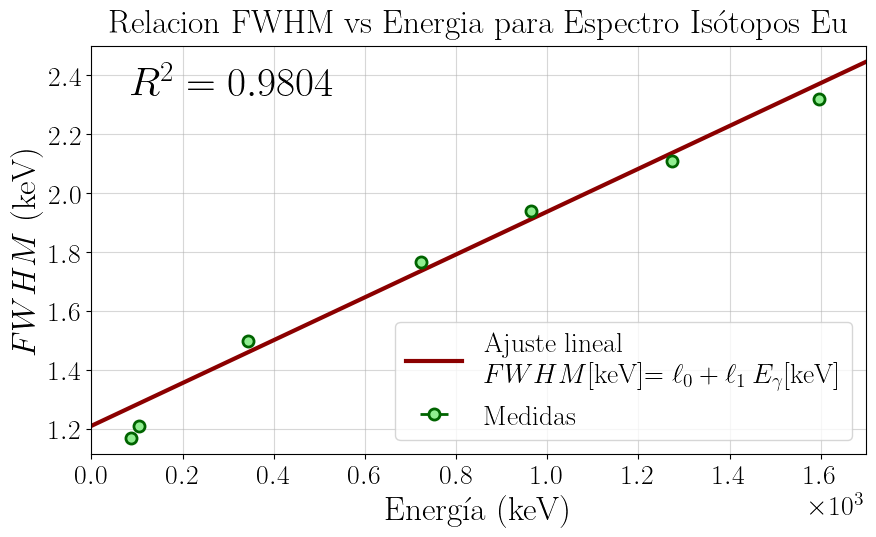

In [29]:
E_gamma_mix = np.array([86.5, 105.3, 344.3, 723.3, 964.1, 1274.5, 1596.5])
fwhm_mix = [3.22, 3.33, 4.127, 4.86, 5.34, 5.812, 6.39]
u_fwhm_mix = [0.04, 0.04, 0.018, 0.03, 0.04, 0.027, 0.06]
fwhm_mix = [un.ufloat(fwhm_mix[i], u_fwhm_mix[i]) for i in range(len(fwhm_mix))]
fwhm_energia_mix = np.array([energia(fwhm_mix[i]).nominal_value for i in range(len(fwhm_mix))])
u_fwhm_energia_mix = np.array([energia(fwhm_mix[i]).std_dev for i in range(len(fwhm_mix))])
fig, ax = linealizacion_FWHM(E_gamma_mix, fwhm_energia_mix, u_fwhm_energia_mix)
ax.set_title("Relacion FWHM vs Energia para Espectro Isótopos Eu")
ax.set_ylim(1.114, 2.5)
ax.set_xlim(0, 1700)
fig.savefig("3_FWHM_lineal_eu.pdf")
plt.show()

c0 = 0.832 ± 0.011
c1 = 3.57702843e-02 ± 4.604e-04


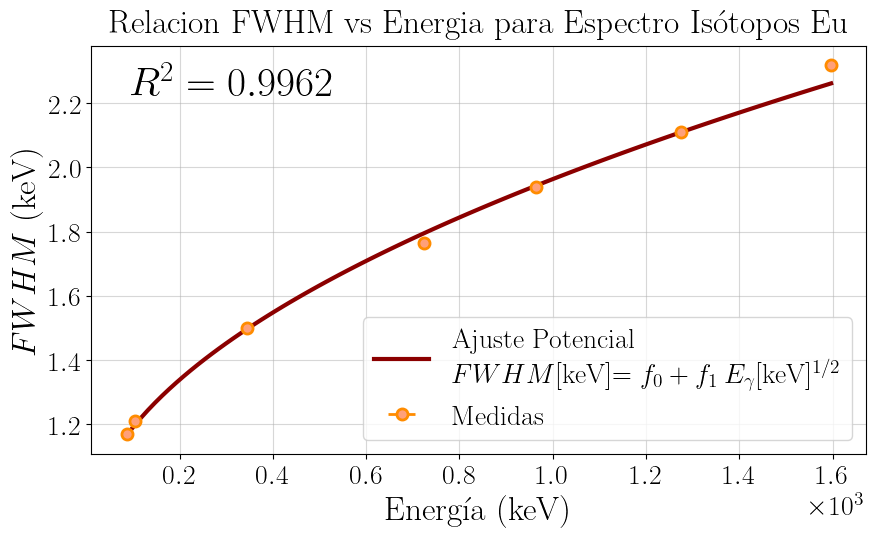

In [30]:
E_gamma_mix = np.array([86.5, 105.3, 344.3, 723.3, 964.1, 1274.5, 1596.5])
fwhm_mix = [3.22, 3.33, 4.127, 4.86, 5.34, 5.812, 6.39]
u_fwhm_mix = [0.04, 0.04, 0.018, 0.03, 0.04, 0.027, 0.06]
fwhm_mix = [un.ufloat(fwhm_mix[i], u_fwhm_mix[i]) for i in range(len(fwhm_mix))]
fwhm_energia_mix = np.array([energia(fwhm_mix[i]).nominal_value for i in range(len(fwhm_mix))])
u_fwhm_energia_mix = np.array([energia(fwhm_mix[i]).std_dev for i in range(len(fwhm_mix))])
fig, ax = linealizacion_FWHM_raiz(E_gamma_mix, fwhm_energia_mix, u_fwhm_energia_mix)
ax.set_title("Relacion FWHM vs Energia para Espectro Isótopos Eu")
fig.savefig("3_FWHM_loglog_eu.pdf")
plt.show()

## 4. Comparación

In [31]:
c1_mix = un.ufloat(3.62727818e-01, 5.002e-04)
c1_eu = un.ufloat(3.63459247e-01, 5.184e-04)

c0_mix = un.ufloat(-26.612, 1.565)
c0_eu = un.ufloat(-26.787, 0.997)

c1_mean = (c1_mix + c1_eu) / 2
c0_mean = (c0_mix + c0_eu) / 2
print(f"Mean of c1: {c1_mean}")
print(f"Mean of c0: {c0_mean}")

a0 = un.ufloat(-40, 8)  # keV
a1 = un.ufloat(3.16, 0.03)  # keV/canal

c0 = c0_mean
c1 = c1_mean
# Calibracion momentanea
def energia_ge(canal):
    return c1 * canal + c0

def canal_ge(energia):
    return (energia - c0) / c1


def energia_nai(canal):
    return a1 * canal + a0

def canal_nai(energia):
    return (energia - a0) / a1


# energia(canales) calibracion hecha
energia_nai(200)

Mean of c1: 0.3631+/-0.0004
Mean of c0: -26.7+/-0.9


592.0+/-10.0

In [49]:
pre_dir = "../Practica 2/data/"
co57 = pd.read_csv(pre_dir + "NaI_57Co_300s.dat", sep=r"\s+")
value_ge = data["mixed"]
df1 = value_ge["file"]
dif = df1['cuentas'].max() / co57['cuentas'].max()

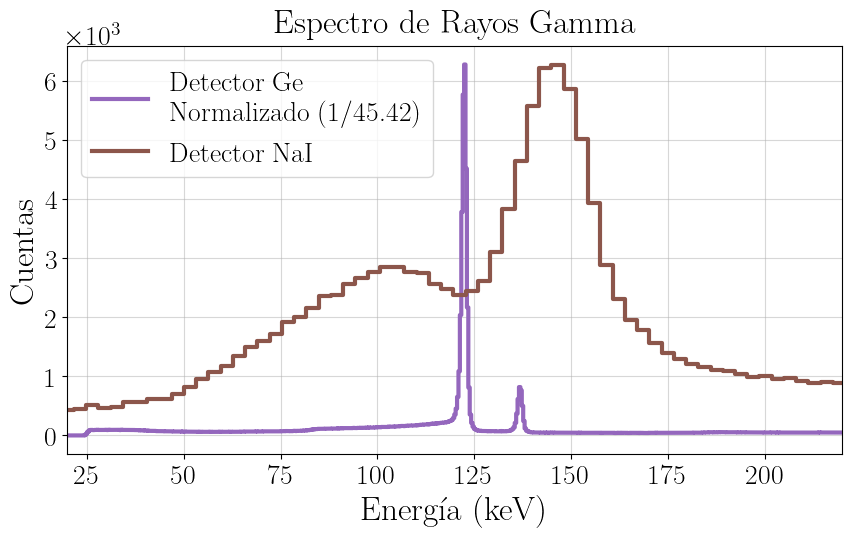

In [55]:
value_ge = data["mixed"]
df1 = value_ge["file"]
df2 = co57

df1["energia"] = np.array([energia_ge(canal).nominal_value for canal in df["canal"]])
df2["energia"] = np.array([energia_nai(canal).nominal_value for canal in df2["canal"]])
# gráfica
fig, ax = plt.subplots(figsize=(10, 6))
df1["cuentas"] = df1["cuentas"] * (df2["cuentas"].max() / df1["cuentas"].max())
ax.plot(df1["energia"], df1["cuentas"], label=f"Detector Ge\nNormalizado (1/{dif:.2f})", lw=3, ds="steps-mid", color=colors[4])
ax.plot(df2["energia"], df2["cuentas"], label="Detector NaI", lw=3, ds="steps-mid", color=colors[5])
ax.set_xlabel("Energía (keV)")
ax.set_ylabel("Cuentas")
ax.set_title("Espectro de Rayos Gamma")
ax.legend()
ax.set_xlim(20, 220)
#ax.set_ylim(0, df1["cuentas"].max() * 1.1)
fig.savefig("4_espectro_combinado_calibrado.pdf")
plt.show()
